# Part #04: Model Validation

## Step #01: Feature Selection REVISITED!

### Set up the workspace

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score, KFold, learning_curve, RandomizedSearchCV, validation_curve
from xgboost import XGBRegressor

In [2]:
# Read the results from before:
with open("./assets/preprocessing_results.pkl", mode="rb") as file_bin:
    resulst = pickle.load(file_bin)

In [3]:
# Unpack train and test sets:
feature_names, X_train, X_test, y_train, y_test = resulst.values()

### Perform step-wise feature elimination to exclude less important features

- What is feature elimination?
> - Feature elimination, also known as feature selection, is the process of selecting a subset of features from a larger set of available features.
> - In machine learning, features refer to the input variables or attributes that are used to train a model and make predictions.
> - Feature elimination is performed to improve model performance, reduce overfitting, and enhance interpretability by focusing on the most informative and relevant features.

- What is step-wise feature elimination?
> - Step-wise feature elimination is a systematic approach to feature selection that iteratively removes less important features from the dataset.
> - The process typically involves the following steps:
>> - Initialization,
>> - Feature importance calculation,
>> - Feature elimination,
>> - Model retraining,
>> - Stopping criteria,
>> - Iterative process,
>> - Final model evaluation.

In [4]:
# Recreate the df for training & test sets:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
X_test_df = pd.DataFrame(data=X_test, columns=feature_names)

In [5]:
# Instantiate a candidate model:
xgb_reg = XGBRegressor()

In [6]:
# Define a scoring function(s):
r2 = make_scorer(r2_score, greater_is_better=True)

Validating current performance...
Validating current performance done in 0.13 minutes!

Validating longitude...
Validating longitude done in 0.08 minutes!

Validating latitude...
Validating latitude done in 0.08 minutes!

Validating housing_median_age...
Validating housing_median_age done in 0.10 minutes!

Validating total_rooms...
Validating total_rooms done in 0.10 minutes!

Validating population...
Validating population done in 0.10 minutes!

Validating median_income...
Validating median_income done in 0.07 minutes!

Validating ocean_proximity_1H OCEAN...
Validating ocean_proximity_1H OCEAN done in 0.10 minutes!

Validating ocean_proximity_INLAND...
Validating ocean_proximity_INLAND done in 0.10 minutes!

Validating ocean_proximity_NEAR BAY...
Validating ocean_proximity_NEAR BAY done in 0.10 minutes!

Validating ocean_proximity_NEAR OCEAN...
Validating ocean_proximity_NEAR OCEAN done in 0.10 minutes!

                               min    mean     max
ocean_proximity_NEAR OCEAN  82.

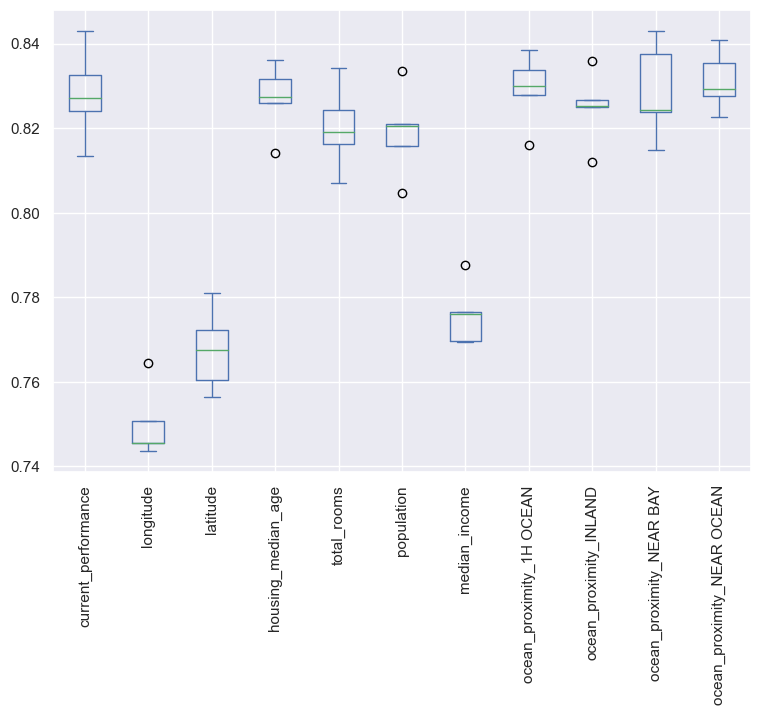

In [7]:
%%time
# Compare different features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [8]:
# Determine irrelevant features:
n_features = 6
irrelevant_features = [f for f in results.index[:n_features] if f != "current_performance"]
irrelevant_features

['ocean_proximity_NEAR OCEAN',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_NEAR BAY',
 'housing_median_age',
 'ocean_proximity_INLAND']

In [9]:
# Drop irrelevant features:
X_train_df = X_train_df.drop(irrelevant_features, axis=1)

Validating current performance...
Validating current performance done in 0.10 minutes!

Validating longitude...
Validating longitude done in 0.08 minutes!

Validating latitude...
Validating latitude done in 0.10 minutes!

Validating total_rooms...
Validating total_rooms done in 0.10 minutes!

Validating population...
Validating population done in 0.08 minutes!

Validating median_income...
Validating median_income done in 0.07 minutes!

                        min    mean     max
current_performance  81.03%  82.60%  83.91%
population           80.38%  81.89%  83.64%
total_rooms          80.34%  81.92%  82.95%
median_income        76.83%  77.37%  77.77%
latitude             65.48%  67.03%  68.97%
longitude            62.44%  63.81%  65.22%


CPU times: total: 1min 51s
Wall time: 33.2 s


<Figure size 640x480 with 0 Axes>

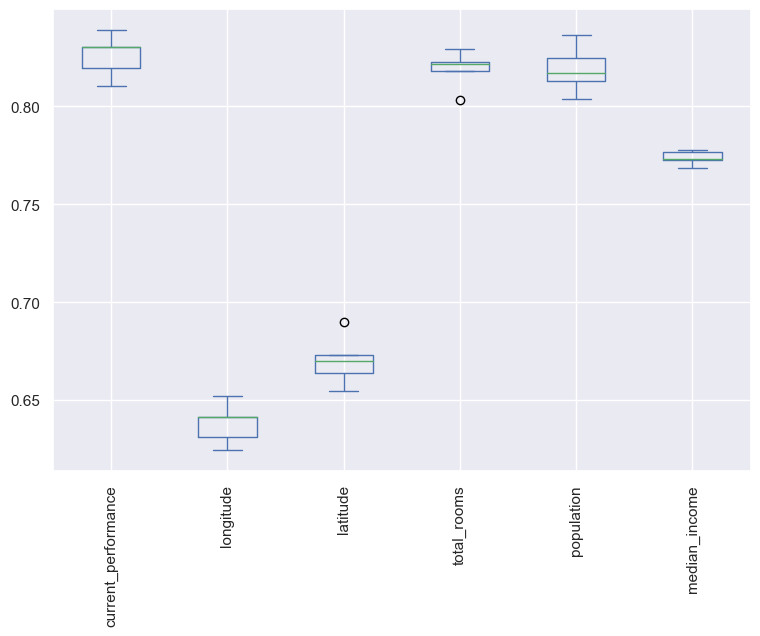

In [10]:
%%time
# Compare remaining features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [11]:
# Drop irrelevant features from test set:
X_test_df = X_test_df.drop(irrelevant_features, axis=1)

In [12]:
# Convert train and test set into numpy arrays:
X_train = X_train_df.to_numpy(dtype=np.float32)
X_test = X_test_df.to_numpy(dtype=np.float32)

In [13]:
# Save feature names for later:
feature_names = X_train_df.columns.tolist()

## Step #02: Plotting the Learning Curve

> - We can gain further insight by exploring the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
> - A plot of the training/validation score with respect to the size of the training set is sometimes known as a learning curve.
> - The general behavior we would expect from a learning curve is this:
>> - A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
>> - A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
>> - A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but
never cross.

In [14]:
%%time
# Perform CV on different sample sizes:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_reg,
    X_train,
    y_train,
    train_sizes=np.linspace(start=0.2, stop=1.0, num=5),
    cv=10,
    scoring=r2,
    random_state=42
)

CPU times: total: 2min 47s
Wall time: 45.8 s


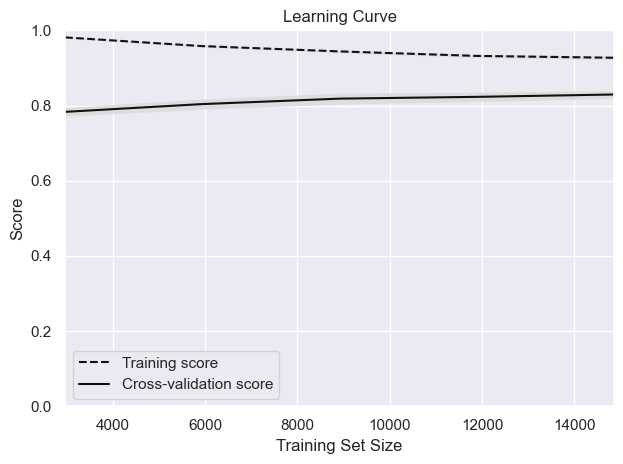

In [15]:
# Plot the learning curve:
%run "./recipes/plot_learning_curve.py"
plot_learning_curve(train_sizes, train_scores, test_scores);

## Step #03: Plotting the Validation Curve(s)

- What are hyperparameters?
> - In machine learning, hyperparameters are the configuration settings of a model that are not learned from the data, but rather set by the developer before training the model.
> - These parameters influence the learning process and affect the model's performance and generalization capability.

- So the next step is to understand how the performance of a model changes as the value of some hyperparameter changes, starting by a DUMMY (but intuitive) approach and then proceeding to a MORE STRUCTURED one (using different search techniques) in the next section.

### Tune `n_estimators`

In [16]:
# Instantiate the model:
xgb_reg = XGBRegressor(random_state=42);

In [17]:
# Create range of values for the hyperparameter in question:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]

In [18]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=n_estimators,
    cv=3,
    scoring=r2
)

CPU times: total: 5min 2s
Wall time: 1min 30s


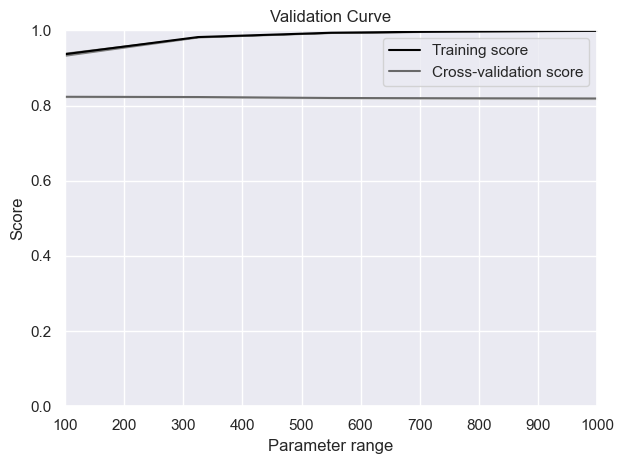

In [19]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(n_estimators, train_scores, test_scores)

In [20]:
best_n_estimators = n_estimators[test_scores.mean(axis=1).argmax()]
best_n_estimators

100

### Tune `learning_rate`

In [21]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    random_state=42
);

In [22]:
# Create range of values for the hyperparameter in question:
learning_rate = [round(x, 3) for x in np.linspace(start=0.01, stop=0.1, num=5)]

In [23]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="learning_rate",
    param_range=learning_rate,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 9s
Wall time: 19.9 s


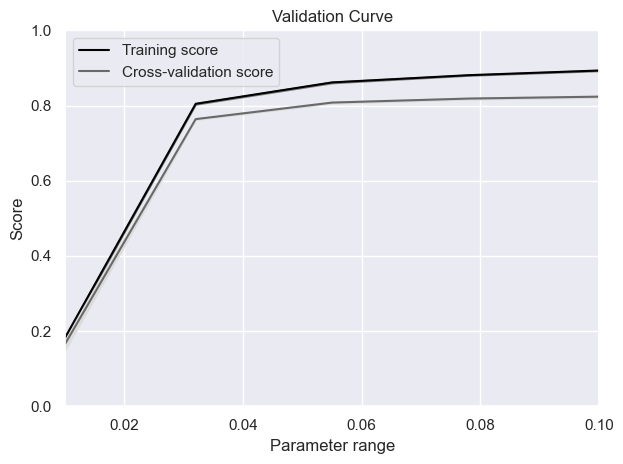

In [24]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(learning_rate, train_scores, test_scores)

In [25]:
best_learning_rate = learning_rate[test_scores.mean(axis=1).argmax()]
best_learning_rate

0.1

### Tune `max_depth`

In [26]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42
);

In [27]:
# Create range of values for the hyperparameter in question:
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=5)]

In [28]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="max_depth",
    param_range=max_depth,
    cv=3,
    scoring=r2
)

CPU times: total: 54.3 s
Wall time: 18.2 s


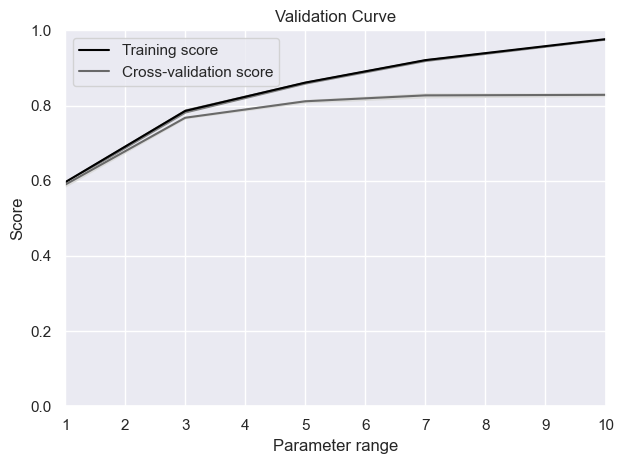

In [29]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(max_depth, train_scores, test_scores)

In [30]:
best_max_depth = max_depth[test_scores.mean(axis=1).argmax()]
best_max_depth

10

### Tune `gamma`

In [31]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    random_state=42
);

In [32]:
# Create range of values for the hyperparameter in question:
gamma = [round(x, 3) for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [33]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="gamma",
    param_range=gamma,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 53s
Wall time: 31.7 s


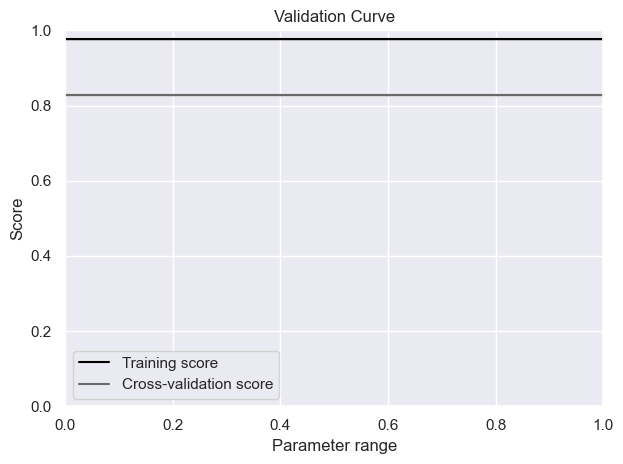

In [34]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(gamma, train_scores, test_scores)

In [35]:
best_gamma = gamma[test_scores.mean(axis=1).argmax()]
best_gamma

0.0

### Tune `min_child_weight`

In [36]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    random_state=42
);

In [37]:
# Create range of values for the hyperparameter in question:
min_child_weight = [int(x) for x in np.linspace(start=1, stop=10, num=5)]

In [38]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="min_child_weight",
    param_range=min_child_weight,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 43s
Wall time: 30.1 s


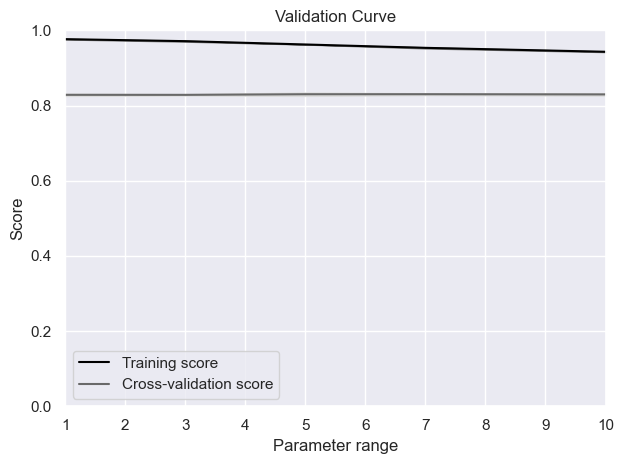

In [39]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(min_child_weight, train_scores, test_scores)

In [40]:
best_min_child_weight = min_child_weight[test_scores.mean(axis=1).argmax()]
best_min_child_weight

7

### Tune `subsample`

In [41]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    min_child_weight=best_min_child_weight,
    random_state=42
);

In [42]:
# Create range of values for the hyperparameter in question:
subsample = [round(x, 3) for x in np.linspace(start=0.1, stop=1.0, num=5)]

In [43]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="subsample",
    param_range=subsample,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 25s
Wall time: 22.1 s


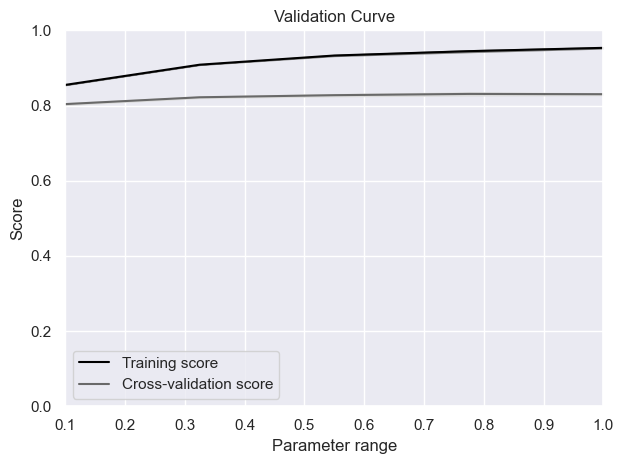

In [44]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(subsample, train_scores, test_scores)

In [45]:
best_subsample = subsample[test_scores.mean(axis=1).argmax()]
best_subsample

0.775

### Tune `colsample_bytree`

In [46]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    random_state=42
);

In [47]:
# Create range of values for the hyperparameter in question:
colsample_bytree = [round(x, 3) for x in np.linspace(start=0.1, stop=1.0, num=5)]

In [48]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="colsample_bytree",
    param_range=colsample_bytree,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 5s
Wall time: 20 s


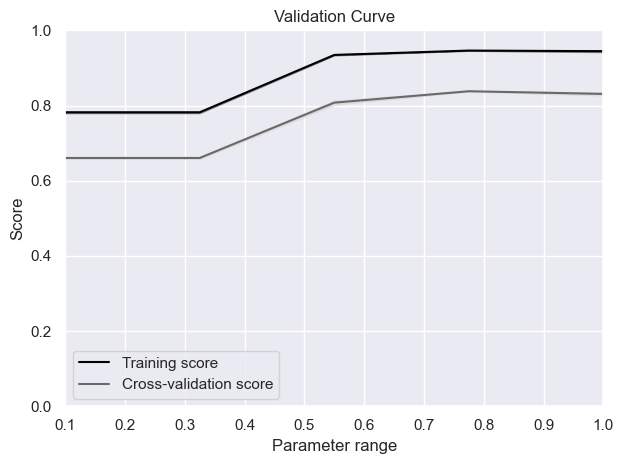

In [49]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(colsample_bytree, train_scores, test_scores)

In [50]:
best_colsample_bytree = colsample_bytree[test_scores.mean(axis=1).argmax()]
best_colsample_bytree

0.775

### Tune `reg_alpha`

In [51]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    random_state=42
);

In [52]:
# Create range of values for the hyperparameter in question:
reg_alpha = [round(x, 3) for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [53]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="reg_alpha",
    param_range=reg_alpha,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 5s
Wall time: 22.2 s


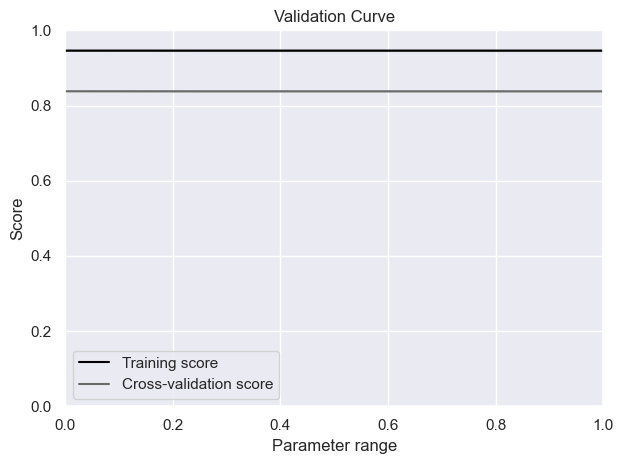

In [54]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(reg_alpha, train_scores, test_scores)

In [55]:
best_reg_alpha = reg_alpha[test_scores.mean(axis=1).argmax()]
best_reg_alpha

0.0

### Tune `reg_lambda`

In [56]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    random_state=42
);

In [57]:
reg_lambda = [round(x, 3) for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [58]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="reg_lambda",
    param_range=reg_lambda,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 27s
Wall time: 24.4 s


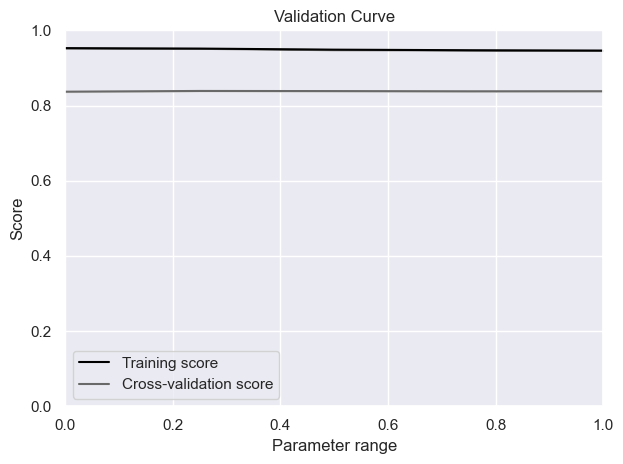

In [59]:
# Plot the validation curve:
%run "./recipes/plot_validation_curve.py"
plot_validation_curve(reg_lambda, train_scores, test_scores)

In [60]:
best_reg_lambda = reg_lambda[test_scores.mean(axis=1).argmax()]
best_reg_lambda

0.25

### Evaluate the model using the best-found hyperparameters (flawed but intuitive approach)

In [61]:
# Instantiate the xgb_reg baseline model:
baseline_xgb_reg = XGBRegressor(random_state=42);

In [62]:
# Instantiate the model:
manual_search_xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    gamma=best_gamma,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda,
    random_state=42
);

Validating baseline_xgb_reg...
Validating baseline_xgb_reg done in 0.13 minutes!

Validating manual_search_xgb_reg...
Validating manual_search_xgb_reg done in 0.13 minutes!

                          min    mean     max
baseline_xgb_reg       81.03%  82.60%  83.91%
manual_search_xgb_reg  82.47%  83.70%  84.44%


CPU times: total: 52.8 s
Wall time: 17.6 s


<Figure size 640x480 with 0 Axes>

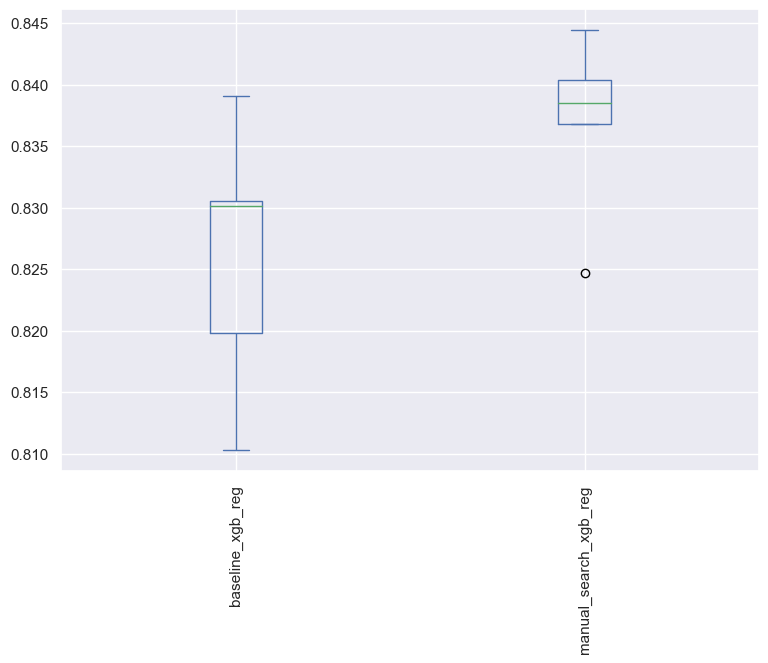

In [63]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=5,
    baseline_xgb_reg=baseline_xgb_reg,
    manual_search_xgb_reg=manual_search_xgb_reg
);

## Step #04: Tuning the Model Hyperparameters

- What is hyperparameter tuning?
> - Hyperparameter tuning is the process of finding the optimal values for the hyperparameters of a machine learning model.
> - By selecting the best hyperparameter values, we can improve the model's performance and achieve better results. 

- Methods of hyperparameter tuning:
> - Grid Search,
> - Randomized Search,
> - Bayesian Optimization.

- Let's compare the last two methods with the same number of rounds.

In [64]:
N_ROUNDS = 50

### Randomized search

- Randomized search allows for exploring a broader range of hyperparameter combinations efficiently.
- It is Particularly useful for large search spaces or limited computational resources.
- Implementation using `sklean`:
> - Define the hyperparameter search space,
> - Sample hyperparameter combinations,
> - Randomly select combinations from the defined search space.

In [65]:
# Instantiate the model:
rand_xgb_reg = XGBRegressor(random_state=42);

In [66]:
# Define the hyperparameters:
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,  
    'gamma': gamma,
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'reg_alpha': reg_alpha,
    'reg_lambda':reg_lambda
}

In [67]:
# Create a RandomizedSearchCV object:
rand_search_cv = RandomizedSearchCV(
    estimator=rand_xgb_reg,
    param_distributions=params,
    n_iter=N_ROUNDS,
    return_train_score=True,
    cv=3,
    random_state=42
)

In [68]:
%%time
# Fit the RandomizedsearchCV object to the training set:
rand_search_cv.fit(X_train, y_train);

CPU times: total: 30min 38s
Wall time: 8min 44s


In [69]:
# Print the best parameters:
rand_cv_best_params = rand_search_cv.best_params_
for k, v in rand_cv_best_params.items():
    print(f"{k} --> {v}")

subsample --> 0.775
reg_lambda --> 1.0
reg_alpha --> 0.5
n_estimators --> 1000
min_child_weight --> 1
max_depth --> 10
learning_rate --> 0.032
gamma --> 0.75
colsample_bytree --> 1.0


In [70]:
# Re-instantiate the best model:
rand_xgb_reg = rand_search_cv.best_estimator_

Validating baseline_xgb_reg...
Validating baseline_xgb_reg done in 0.10 minutes!

Validating manual_search_xgb_reg...
Validating manual_search_xgb_reg done in 0.13 minutes!

Validating rand_xgb_reg...
Validating rand_xgb_reg done in 1.82 minutes!

                          min    mean     max
baseline_xgb_reg       81.03%  82.60%  83.91%
manual_search_xgb_reg  82.47%  83.70%  84.44%
rand_xgb_reg           82.07%  83.81%  84.95%


CPU times: total: 7min 14s
Wall time: 2min 4s


<Figure size 640x480 with 0 Axes>

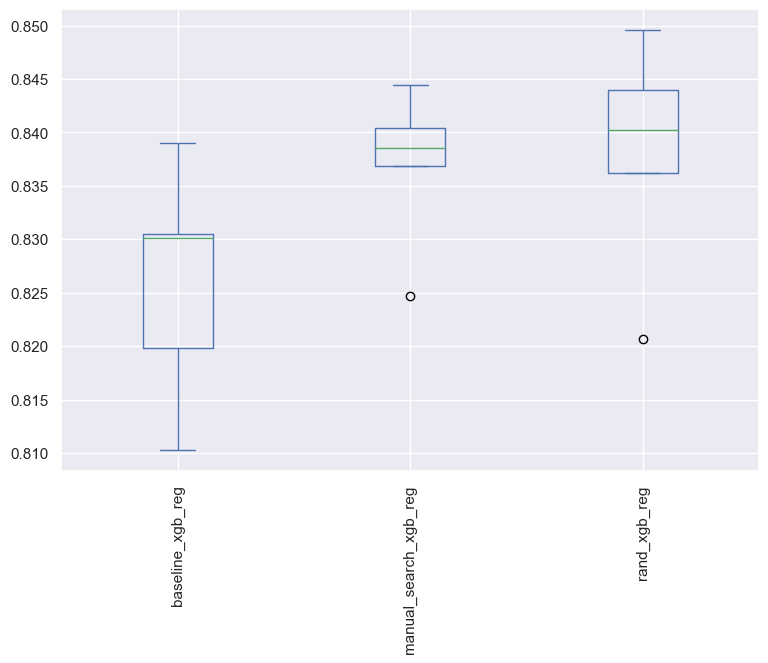

In [71]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=5,
    baseline_xgb_reg=baseline_xgb_reg,
    manual_search_xgb_reg=manual_search_xgb_reg,
    rand_xgb_reg=rand_xgb_reg
);

### Bayesian optimization

- Implementation using `optuna`:
> - `optuna` is a Python library for hyperparameter optimization.
> - It provides a flexible and easy-to-use framework for implementing hyperparameter tuning in machine learning projects.
> - Here's a basic outline of how to use Optuna for hyperparameter tuning:
>> - Define the `objective` function,
>> - Define the hyperparameter search space,
>> - Create and run a `study` object.

In [72]:
# Set optuna log level to WARNINGonly:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [73]:
# Define the objective function:
def objective(trial):
    
    # Define the hyperparameters:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),  
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    # Train the model with CV:
    xgb_reg = XGBRegressor(random_state=42, **params)
    cv_results = cross_val_score(xgb_reg, X_train, y_train, scoring=r2, cv=3)

    # Evaluate the model
    r2_score = cv_results.mean()

    return r2_score

In [74]:
# Create a study:
study = optuna.create_study(direction='maximize');

In [75]:
%%time
# Run the study:
study.optimize(objective, n_trials=N_ROUNDS)

CPU times: total: 1h 3min 35s
Wall time: 18min 34s


In [76]:
# Print the best parameters:
opt_cv_best_params = study.best_params
for k, v in opt_cv_best_params.items():
    print(f"{k} --> {v}")

n_estimators --> 690
learning_rate --> 0.025588282672416106
max_depth --> 10
gamma --> 0.9980215915605994
min_child_weight --> 2
subsample --> 0.7171106027287092
colsample_bytree --> 0.8659604516408241
reg_alpha --> 0.7655636745868237
reg_lambda --> 0.7551675327176233


In [77]:
# Train the model with the best parameters:
optimized_xgb_reg = XGBRegressor(**opt_cv_best_params)
optimized_xgb_reg.fit(X_train, y_train);

Validating baseline_xgb_reg...
Validating baseline_xgb_reg done in 0.13 minutes!

Validating manual_search_xgb_reg...
Validating manual_search_xgb_reg done in 0.18 minutes!

Validating rand_xgb_reg...
Validating rand_xgb_reg done in 2.65 minutes!

Validating optimized_xgb_reg...
Validating optimized_xgb_reg done in 1.40 minutes!

                          min    mean     max
baseline_xgb_reg       81.03%  82.60%  83.91%
manual_search_xgb_reg  82.47%  83.70%  84.44%
rand_xgb_reg           82.07%  83.81%  84.95%
optimized_xgb_reg      83.14%  84.45%  85.15%


CPU times: total: 14min 35s
Wall time: 4min 25s


<Figure size 640x480 with 0 Axes>

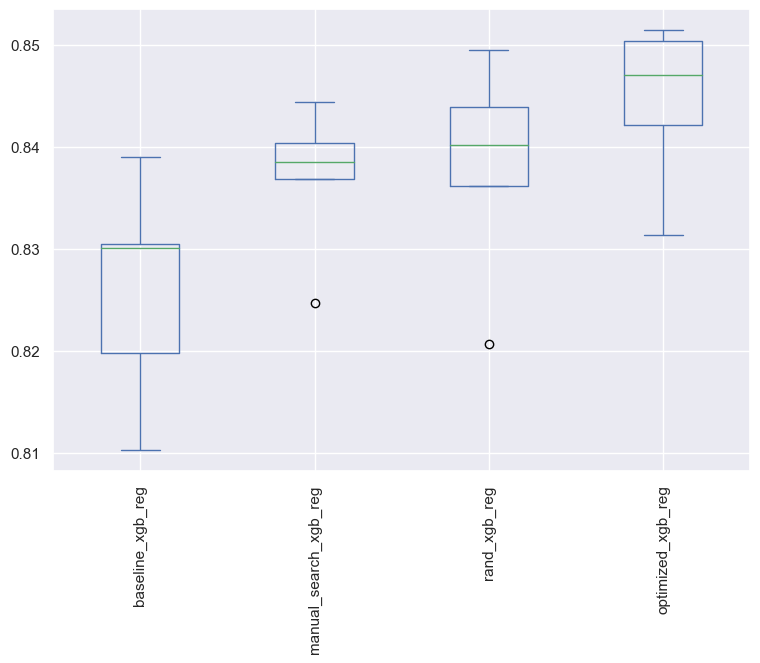

In [78]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=5,
    baseline_xgb_reg=baseline_xgb_reg,
    manual_search_xgb_reg=manual_search_xgb_reg,
    rand_xgb_reg=rand_xgb_reg,
    optimized_xgb_reg=optimized_xgb_reg
);

- Is there any room for improvement by running more rounds of optimization?

C:\Users\MOHEB_MAHER\AppData\Local\Temp\ipykernel_13248\2367543774.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study);


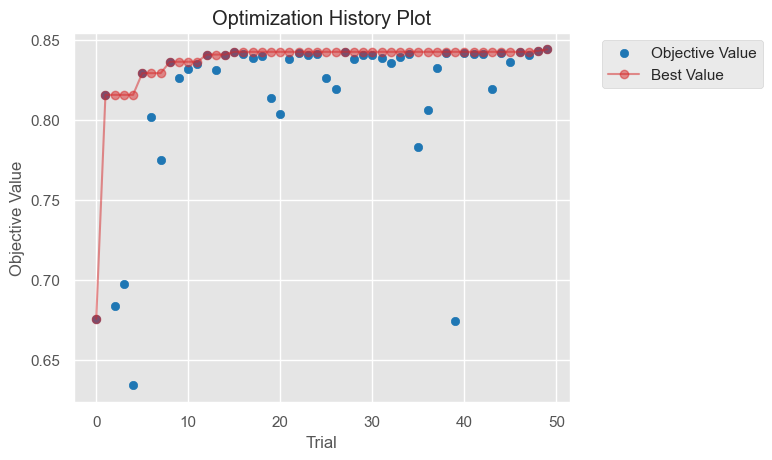

In [79]:
# Plot optimization history:
optuna.visualization.matplotlib.plot_optimization_history(study);

- Are all hyperparameters equally important?

C:\Users\MOHEB_MAHER\AppData\Local\Temp\ipykernel_13248\3626191014.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study);


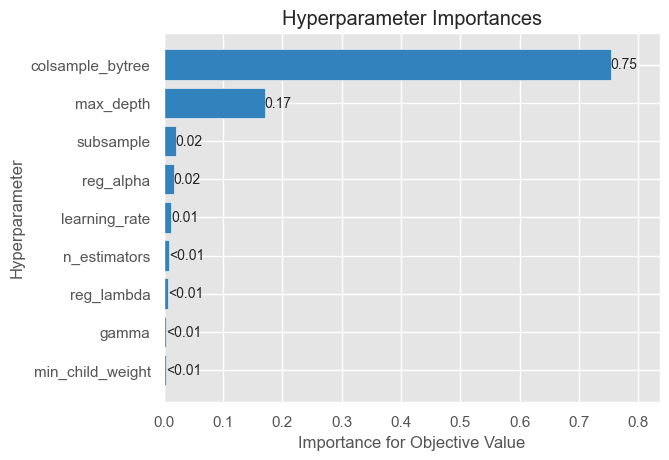

In [80]:
# Plot hyperparameter importances:
optuna.visualization.matplotlib.plot_param_importances(study);

## Step #05: Final Model Evaluation

In [81]:
# Instantiate the best model so far:
best_xgb_reg = XGBRegressor(**opt_cv_best_params)

In [82]:
# Fit the model:
best_xgb_reg.fit(X_train, y_train);

In [83]:
# Evaluate the model using r2:
best_r2_score = r2(best_xgb_reg, X_test, y_test)
print(f"R-squared = {best_r2_score:.2%}")

R-squared = 85.39%


## Step #06: Saving Results

- Pickle training and testing set after feature elimination:

In [84]:
# Create a dictionary to hold the results:
feature_elimination_results = {
    "feature_names": feature_names,
    "X_train": X_train.astype(np.float32),
    "X_test": X_test.astype(np.float32),
    "y_train": y_train.astype(np.float32),
    "y_test": y_test.astype(np.float32)
}

In [85]:
# Pickle the results:
with open("./assets/feature_elimination_results.pkl", mode="wb") as file_bin:
    pickle.dump(feature_elimination_results, file_bin)

- Pickle the best `xgb_reg`:

In [86]:
with open("./assets/best_xgb_reg.pkl", mode="wb") as file_bin:
    pickle.dump(best_xgb_reg, file_bin)

- Also, you can save it as a `.json` file:

In [87]:
# Save the model:
best_xgb_reg.save_model("./assets/best_xgb_reg.json")

In [88]:
# Load the saved model:
saved_xgb_reg = XGBRegressor()
saved_xgb_reg.load_model("./assets/best_xgb_reg.json");